In [1]:
import os
import sys
%cd ..
from tqdm.auto import tqdm
from utils import get_data,ColumnsPreprocessing,get_specific_df,ColumnsTrainKfold,seedEverything,grid_parameters_name,grid_parameters,TrainOneFold,get_cv_split
from sklearn.model_selection import GridSearchCV
from stg_fs import get_stg_class,get_SelectFdr_class,get_mrmr_class,get_reliefF_class,get_RFE_SVM_class,get_FWDT_class,get_ensemble_class, get_ensemble_class_new ,get_stg_class_new,get_FWDT_class_new
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from joblib import Parallel, delayed
import pickle
from calculate_metric_score import get_score
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from main import *

/sise/liorrk-group/OrDanOfir/lior.exp.4
Start


In [2]:
datsets_num = -1
Filtering_Algorithm = 'f_classif'
os.makedirs(f"temp/{Filtering_Algorithm}/",exist_ok=True)
df,name = pd.read_csv('/sise/liorrk-group/OrDanOfir/data/microarrays/data_toy_example//SPECTF_train.csv'),'toy_example'
PP = ColumnsPreprocessing(columns=name)
get_stg_fun = Filtering[Filtering_Algorithm](datasets=name,out_path=f'temp/{Filtering_Algorithm}')

## Run train pipeline with sklean Fit Pipeline - No split (checking that everything works)

In [3]:
train_features,y = PP.transform(df)
Filtering_Algorithm = 'f_classif'
estimators = [("Filtering",SelectKBest(get_stg_fun,k=10)), ('clf', KNeighborsClassifier())]
pipe = Pipeline(estimators)
pipe.fit(train_features,y)
pred = pipe.predict_proba(train_features)
get_score(y,pred)

{'MCC': 0.6855795667606844,
 'ACC': 0.8375,
 'AUC': 0.9271874999999999,
 'PR-AUC': 0.9146969696969697}

# Use GridSearchCV to find best param

In [4]:
grid_parameters ={
                'clf__n_neighbors': [2,5,10],
                'clf__algorithm': ['auto'],
                'clf__weights': ['uniform', 'distance']
            }
grid = GridSearchCV(pipe, param_grid=grid_parameters, cv=5)
_ = grid.fit(train_features,y)
best_params = {}
for row in grid.best_params_:
    best_params[row.split("__")[-1]] = grid.best_params_[row]
best_params

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

# Train K-fold with best param

In [5]:
df,name = get_specific_df(datsets_num)
skf,n_splits,name_cv = get_cv_split(df)
train_features,y = PP.transform(df)
score_dict = {}
all_pred = []
all_val = []
run_only_cv = False if "Folds" in name_cv else True
split_fun = skf.split(train_features, y) if "Folds" in name_cv else skf.split(train_features)
train_features = train_features.values
for fold,(train_index, test_index) in enumerate(tqdm(split_fun,total=n_splits)):
    if not run_only_cv:
        get_stg_fun = Filtering[Filtering_Algorithm](datasets=name,out_path=f'temp/{Filtering_Algorithm}')
    estimators = [("Filtering",SelectKBest(get_stg_fun,k=10)), ('clf', KNeighborsClassifier(**best_params))]
    pipe = Pipeline(estimators)
    X_train, X_test = train_features[train_index].copy(), train_features[test_index].copy()
    y_train, y_test = y[train_index].copy(), y[test_index].copy()
    pipe.fit(X_train,y_train)
    pred = pipe.predict_proba(X_test)
    if not run_only_cv:
        score_dict[fold] = get_score(y_test,pred)
    all_pred.append(pred)
    all_val.append(y_test)
all_pred = np.concatenate(all_pred)
all_val = np.concatenate(all_val)
score_dict['cv_score'] = get_score(all_val,all_pred)
score_dict

100%|██████████| 10/10 [00:00<00:00, 49.42it/s]


{0: {'MCC': 0.5773502691896258,
  'ACC': 0.75,
  'AUC': 0.625,
  'PR-AUC': 0.7678571428571428},
 1: {'MCC': 0.0, 'ACC': 0.5, 'AUC': 0.625, 'PR-AUC': 0.7678571428571428},
 2: {'MCC': 0.7745966692414834, 'ACC': 0.875, 'AUC': 1.0, 'PR-AUC': 1.0},
 3: {'MCC': 0.5773502691896258, 'ACC': 0.75, 'AUC': 1.0, 'PR-AUC': 1.0},
 4: {'MCC': 0.7745966692414834,
  'ACC': 0.875,
  'AUC': 0.8125,
  'PR-AUC': 0.8928571428571428},
 5: {'MCC': 0.3779644730092272,
  'ACC': 0.625,
  'AUC': 0.75,
  'PR-AUC': 0.8303571428571428},
 6: {'MCC': 0.7745966692414834, 'ACC': 0.875, 'AUC': 1.0, 'PR-AUC': 1.0},
 7: {'MCC': 0.7745966692414834, 'ACC': 0.875, 'AUC': 0.875, 'PR-AUC': 0.8875},
 8: {'MCC': 0.7745966692414834, 'ACC': 0.875, 'AUC': 1.0, 'PR-AUC': 1.0},
 9: {'MCC': 0.7745966692414834, 'ACC': 0.875, 'AUC': 0.9375, 'PR-AUC': 0.95},
 'cv_score': {'MCC': 0.5980586126161953,
  'ACC': 0.7875,
  'AUC': 0.8356250000000001,
  'PR-AUC': 0.8690055177836468}}

(44,)
ensemble
{'MCC': 0.3259179368665351, 'ACC': 0.6625, 'AUC': 0.7703125000000001, 'PR-AUC': 0.7538129794673454}
**********
STG
{'MCC': 0.48244488031307425, 'ACC': 0.7375, 'AUC': 0.8134375, 'PR-AUC': 0.7790440880958123}
**********
(44,)
FWDT
{'MCC': 0.47634160003570514, 'ACC': 0.7375, 'AUC': 0.82875, 'PR-AUC': 0.790914757580355}
**********
(44,)
ensemble
{'MCC': 0.6, 'ACC': 0.8, 'AUC': 0.845, 'PR-AUC': 0.8156146304675717}
**********
STG
{'MCC': 0.6769064842612652, 'ACC': 0.8375, 'AUC': 0.8775, 'PR-AUC': 0.8332017162044523}
**********
(44,)
FWDT
{'MCC': 0.6267652632048752, 'ACC': 0.8125, 'AUC': 0.8681249999999999, 'PR-AUC': 0.8381385146563713}
**********
(44,)
ensemble
{'MCC': 0.47634160003570514, 'ACC': 0.7375, 'AUC': 0.7946875, 'PR-AUC': 0.7317475771882136}
**********
STG
{'MCC': 0.4875001055012461, 'ACC': 0.7375, 'AUC': 0.8153125, 'PR-AUC': 0.7728517722878626}
**********
(44,)
FWDT
{'MCC': 0.4787549991450211, 'ACC': 0.7375, 'AUC': 0.8328125000000001, 'PR-AUC': 0.8186266896750072}
*

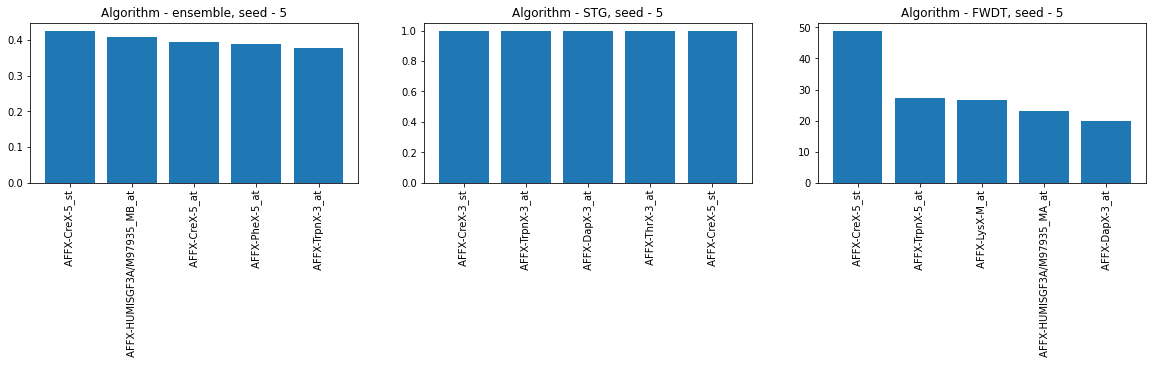

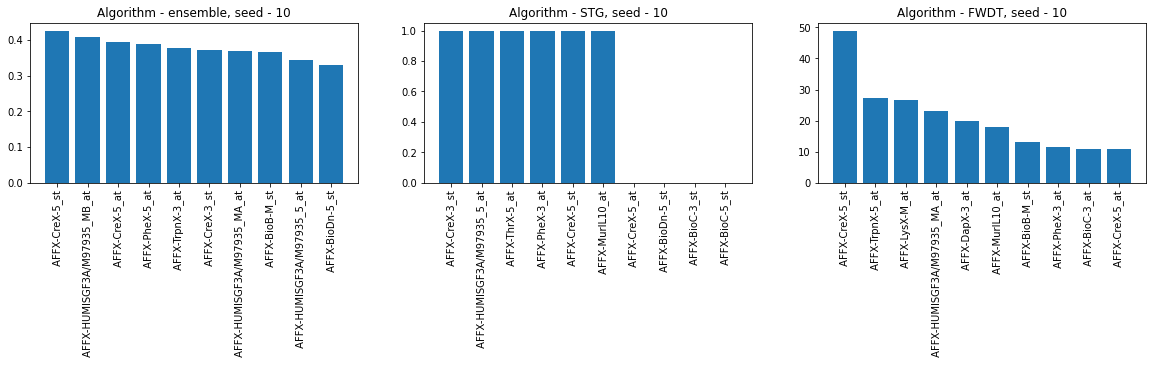

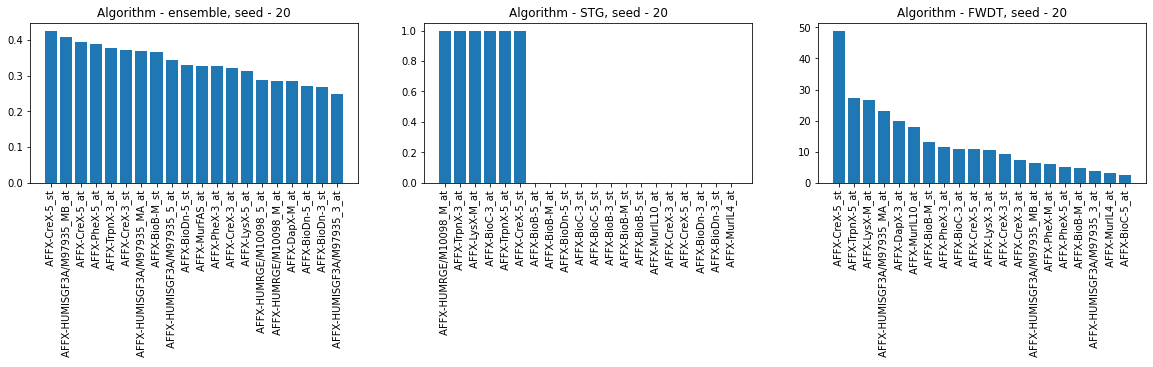

In [7]:
row=0
for seed in [5,10,20]:
    plt.figure(figsize=[20,10])
    for Filtering_Algorithm in ['ensemble','STG','FWDT']:#,'STG']:
        k = seed
        seedEverything(seed)
        get_stg_fun = Filtering[Filtering_Algorithm](datasets=name,out_path=f'temp/{Filtering_Algorithm}')
        score_gates = get_stg_fun(train_features,y.values)
        topk = score_gates.argsort()[::-1][0:k]
        col_name = np.array(df.drop('target',axis=1).columns)[topk]
        score_gates = score_gates[topk] 
        plt.subplot(3,3,row+1)
        plt.bar(col_name,score_gates)
        plt.xticks(rotation=90)
        plt.title(f"Algorithm - {Filtering_Algorithm}, seed - {seed}")
        estimators = [("Filtering",SelectKBest(get_stg_fun,k=k)), ('clf', KNeighborsClassifier())]
        pipe = Pipeline(estimators)
        pipe.fit(train_features,y)
        pred = pipe.predict_proba(train_features)
        print(Filtering_Algorithm)
        print(get_score(y,pred))
        print('*'*10)
        row+=1